In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV


StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 3, Finished, Available, Finished)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load the data
spark_df = spark.read.table("cervical_cancer_data_cleaned")
display(spark_df)

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6becc787-cfc5-4cbc-aa7e-e2a98ba5f5e8)

In [3]:
pandas_df = spark_df.toPandas()
filtered_df = pandas_df[
    (pandas_df["Age"] < 55) &
    (pandas_df["NumOfPregnancies"] < 7) &
    (pandas_df["SmokesYears"] < 5) &
    (pandas_df["SmokesPacksYear"] < 21) &
    (pandas_df["IUDYears"] < 12) &
    (pandas_df["STDsNumber"] < 5) &
    (pandas_df["STDsNumberOfDiagnosis"] < 2)
]
filtered_df

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 5, Finished, Available, Finished)

,Age,NumberOfSexualPartners,FirstSexualIntercourse,NumOfPregnancies,Smokes,SmokesYears,SmokesPacksYear,HormonalContraceptives,HormonalContraceptivesYears,IUD,...,STDsGenitalHerpes,STDsHIV,STDsNumberOfDiagnosis,DxCancer,DxHPV,Dx,Hinselmann,Schiller,Citology,Biopsy
3,24,3,18,2,1,1,1,1,5,0,...,0,0,0,0,0,0,0,0,0,0
6,23,3,17,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,17,3,13,1,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,37,3,24,1,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,36,3,18,3,1,1,2,1,9,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,19,1,17,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
664,19,1,17,1,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
665,24,1,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
666,27,1,17,1,0,0,0,1,4,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def optimize_memory(df):
    df = df.copy()  # Ensure we're not modifying a view
    for col in df.columns:
        if df[col].dtype == 'float64':
            df.loc[:, col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df.loc[:, col] = df[col].astype('int32')
    return df

filtered_df = optimize_memory(filtered_df)
print("Memory optimized")

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 6, Finished, Available, Finished)

Memory optimized


In [5]:
# Split the dataset
y = filtered_df["Biopsy"]
X = filtered_df.drop(columns = ["Biopsy"])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 7, Finished, Available, Finished)

In [6]:
#Apply SelectFromModel
selector_model = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)

X_train_model = selector_model.fit_transform(X_train, y_train)
X_test_model = selector_model.transform(X_test)

#Retrieve the names of the selected columns
selected_columns = selector_model.get_feature_names_out()

# Recreate dataframes
X_train = pd.DataFrame(X_train_model, columns=selected_columns)
X_test = pd.DataFrame(X_test_model, columns=selected_columns)

#Selected columns
print(selected_columns)

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 8, Finished, Available, Finished)

['Age' 'NumberOfSexualPartners' 'FirstSexualIntercourse'
 'NumOfPregnancies' 'HormonalContraceptives' 'HormonalContraceptivesYears'
 'IUDYears' 'STDsNumber' 'STDsGenitalHerpes' 'Hinselmann' 'Schiller'
 'Citology']


In [7]:
# Model training

catboost = CatBoostClassifier(
    auto_class_weights='Balanced', 
    random_seed=42,
    depth=5,
    verbose=0, 
    thread_count=1
)

print("Training...")
catboost.fit(X_train, y_train)

y_pred_catboost = catboost.predict(X_test)

print(classification_report(y_test, y_pred_catboost))

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 9, Finished, Available, Finished)

Training...
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       111
           1       0.73      1.00      0.84         8

    accuracy                           0.97       119
   macro avg       0.86      0.99      0.91       119
weighted avg       0.98      0.97      0.98       119



StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 10, Finished, Available, Finished)

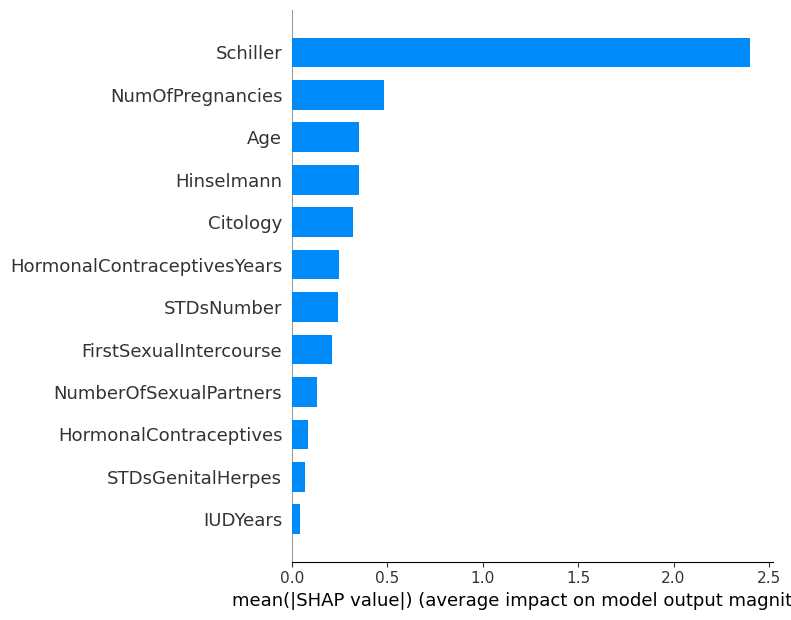

In [8]:
# Features importances analysis

explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [9]:
# Save the model
catboost.save_model('/lakehouse/default/Files/models/cancerPredictionModelDeployed_catBoost.cbm')

StatementMeta(, 9b7d921f-d181-4924-8193-7a68db54a856, 11, Finished, Available, Finished)